In [72]:
library(dplyr)

# Suppress warnings
options(warn = -1)

# Set display options
options(digits = 2)
options(width = 120)

# Set global theme options for ggplot2
theme_set(theme_minimal(base_size = 18))  # Equivalent to setting `titlesize`

input_dir <- file.path(getwd(), "..", "..", "data-files", "spotify_data")
file_list <- list.files(input_dir, recursive = TRUE, full.names = TRUE)
print(file_list)

[1] "/Users/christophermead/posit/qa-example-content/workspaces/large_r_notebook/../../data-files/spotify_data/data.csv"


In [73]:
library(readr)

data_file_path <- file.path(getwd(), "..", "..", "data-files", "spotify_data", "data.csv")
df <- read_csv(data_file_path)

# Print the first few rows
head(df)

Rows: 170653 Columns: 19
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): artists, id, name, release_date
dbl (15): valence, year, acousticness, danceability, duration_ms, energy, explicit, instrumentalness, key, liveness,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 6 × 19
  valence  year acousticness artists      danceability duration_ms energy explicit id    instrumentalness   key liveness
    <dbl> <dbl>        <dbl> <chr>               <dbl>       <dbl>  <dbl>    <dbl> <chr>            <dbl> <dbl>    <dbl>
1  0.0594  1921        0.982 ['Sergei Ra…        0.279      831667  0.211        0 4BJq…       0.878         10    0.665
2  0.963   1921        0.732 ['Dennis Da…        0.819      180533  0.341        0 7xPh…       0              7    0.16 
3  0.0394  1921        0.961 ['KHP Kridh…        0.328      500062  0.166        0 1o6I…       0.913          3    0.101
4  0.165   1921        0.967 ['Frank Par…        0.275      210000  0.309        0 3ftB…       0.0000277      5    0.381
5  0.253   1921        0.957 ['Phil Rega…        0.418      166693  0.193        0 4d6H…       0.00000168     3    0.229
6  0.196   1921        0.579 ['KHP Kridh…        0.697      395076  0.346        0 4pyw…       0.168          2    0.13 
# ℹ 7 more va

In [74]:
# Define mappings as named vectors
map_key <- c(
  "0" = "C", "1" = "C#", "2" = "D", "3" = "D#", "4" = "E",
  "5" = "F", "6" = "F#", "7" = "G", "8" = "G#", "9" = "A",
  "10" = "A#", "11" = "B"
)

map_mode <- c("1" = "Major", "0" = "Minor")

# Apply the mappings to the 'mode' and 'key' columns
df$mode <- map_mode[as.character(df$mode)]
df$key <- map_key[as.character(df$key)]

In [75]:
# Select columns to check for duplicates
check_dups <- df[, c("artists", "name")]

# Find duplicated rows and get their indices
dups <- which(duplicated(check_dups))

In [76]:
# Print the row count before dropping duplicates
cat("Before dropping duplicates:", nrow(df), "rows\n")

# Drop duplicates using the indices found previously
df <- df[-dups, ]

# Print the row count after dropping duplicates
cat("After dropping duplicates:", nrow(df), "rows\n")

Before dropping duplicates: 170653 rows
After dropping duplicates: 157685 rows


In [77]:
# Convert duration from milliseconds to minutes
df$duration_ms <- df$duration_ms / 60000

# Rename the column
colnames(df)[colnames(df) == "duration_ms"] <- "duration_min"

# Display the first few rows to verify
head(df)

# A tibble: 6 × 19
  valence  year acousticness artists     danceability duration_min energy explicit id    instrumentalness key   liveness
    <dbl> <dbl>        <dbl> <chr>              <dbl>        <dbl>  <dbl>    <dbl> <chr>            <dbl> <chr>    <dbl>
1  0.0594  1921        0.982 ['Sergei R…        0.279        13.9   0.211        0 4BJq…       0.878      A#       0.665
2  0.963   1921        0.732 ['Dennis D…        0.819         3.01  0.341        0 7xPh…       0          G        0.16 
3  0.0394  1921        0.961 ['KHP Krid…        0.328         8.33  0.166        0 1o6I…       0.913      D#       0.101
4  0.165   1921        0.967 ['Frank Pa…        0.275         3.5   0.309        0 3ftB…       0.0000277  F        0.381
5  0.253   1921        0.957 ['Phil Reg…        0.418         2.78  0.193        0 4d6H…       0.00000168 D#       0.229
6  0.196   1921        0.579 ['KHP Krid…        0.697         6.58  0.346        0 4pyw…       0.168      D        0.13 
# ℹ 7 more va

In [78]:
# Drop columns "release_date" and "id"
df$release_date <- NULL
df$id <- NULL

# Display the first few rows to verify
head(df)

# A tibble: 6 × 17
  valence  year acousticness artists  danceability duration_min energy explicit instrumentalness key   liveness loudness
    <dbl> <dbl>        <dbl> <chr>           <dbl>        <dbl>  <dbl>    <dbl>            <dbl> <chr>    <dbl>    <dbl>
1  0.0594  1921        0.982 ['Serge…        0.279        13.9   0.211        0       0.878      A#       0.665   -20.1 
2  0.963   1921        0.732 ['Denni…        0.819         3.01  0.341        0       0          G        0.16    -12.4 
3  0.0394  1921        0.961 ['KHP K…        0.328         8.33  0.166        0       0.913      D#       0.101   -14.8 
4  0.165   1921        0.967 ['Frank…        0.275         3.5   0.309        0       0.0000277  F        0.381    -9.32
5  0.253   1921        0.957 ['Phil …        0.418         2.78  0.193        0       0.00000168 D#       0.229   -10.1 
6  0.196   1921        0.579 ['KHP K…        0.697         6.58  0.346        0       0.168      D        0.13    -12.5 
# ℹ 5 more va

In [79]:
library(ggplot2)
library(gridExtra)

fun_subplots_ggplot <- function(df, col) {
    mean_val <- mean(df[[col]], na.rm = TRUE)
    median_val <- median(df[[col]], na.rm = TRUE)

    # Create histogram
    histogram_plot <- ggplot(df, aes_string(x = col)) +
        geom_histogram(binwidth = (max(df[[col]], na.rm = TRUE) - min(df[[col]], na.rm = TRUE)) / 50, 
                       fill = "#EBA0AC", color = "black") +
        labs(title = paste("Histogram of", col), x = col, y = "Count") +
        theme_minimal()

    # Create boxplot
    boxplot <- ggplot(df, aes_string(y = col)) +
        geom_boxplot(fill = "#F9E2AF") +
        labs(title = paste("Boxplot of", col), y = col) +
        theme_minimal()

    # Combine plots
    combined_plot <- grid.arrange(
        histogram_plot,
        boxplot,
        ncol = 2
    )

    # Add mean and median lines
    combined_plot <- combined_plot +
        geom_vline(xintercept = mean_val, color = "#A6E3A1", linetype = "dashed", size = 1) +
        geom_vline(xintercept = median_val, color = "#CBA6F7", linetype = "dashed", size = 1) +
        annotate("text", x = mean_val, y = 0, label = paste("Mean =", round(mean_val, 2)), 
                 vjust = -1, color = "#A6E3A1") +
        annotate("text", x = median_val, y = 0, label = paste("Median =", round(median_val, 2)), 
                 vjust = -1, color = "#CBA6F7")

    print(combined_plot)
}

NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL


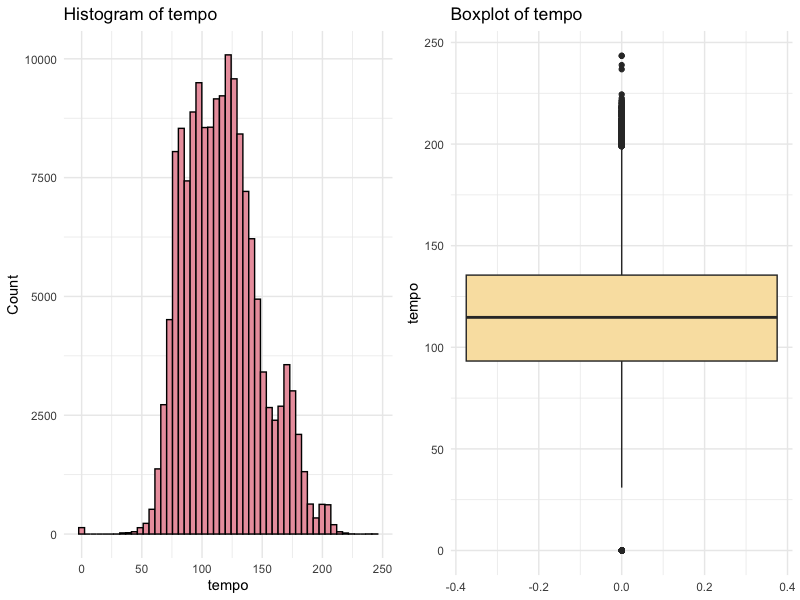

In [80]:
music_vals <- c(
  "valence",
  "acousticness",
  "danceability",
  "duration_min",
  "energy",
  "instrumentalness",
  "liveness",
  "loudness",
  "popularity",
  "speechiness",
  "tempo"
)

for (col in music_vals) {
  fun_subplots_ggplot(df, col)
}